# 2D-CNN pipeline (images ready)

In [2]:
# =============================================
# ====== 1. Imports & Setup ======
# =============================================
import os, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import iqr
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# =============================================
# ====== 2. Google Drive Mount & Paths ======
# =============================================
from google.colab import drive
drive.mount('/content/drive/')

# # Unzip if needed
# !unzip /content/CR.zip -d /content/CR


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# base = os.path.join(base_path, "CR_16_snake_auto_scale")
base = "CR_16_snake_auto_scale"
IMG_DIR = "/content/drive/MyDrive/Spectra2Image/IMGs/CR_16_snake_auto_scale"
CSV_PATH = "/content/drive/MyDrive/Spectra2Image/target_train_488.csv"

In [5]:
# =============================================
# ====== 3. Configurations ======
# =============================================
TARGETS = ['Moi', 'NDF', 'Starch']
IMG_SIZE = 65                           #16
batch_size = 50
epochs = 200
lr = 0.0001
n_splits = 5
seed = 42
plot_name = "CR"

# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
# =============================================
# ====== 4. Data Loading & Scaling ======
# =============================================
df = pd.read_csv(CSV_PATH)
print("Data shape:", df.shape)

# Scale targets
y_scaler = StandardScaler()   # Auto-scale
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

Data shape: (488, 3)


In [7]:
# =============================================
# ====== 5. Dataset Class ======
# =============================================
class SoilImageDataset(Dataset):
    def __init__(self, df, img_dir, targets_scaled, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.targets = targets_scaled.astype(np.float32)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{plot_name}_{idx}.png")
        if not os.path.exists(img_path):
          raise FileNotFoundError(f"Image not found: {img_path}")
        img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
        img = self.transform(img)
        target = torch.from_numpy(self.targets[idx])
        return img, target

transform = transforms.Compose([transforms.ToTensor()])
dataset = SoilImageDataset(df, IMG_DIR, targets_scaled, transform)
print("Dataset length:", len(dataset))

Dataset length: 488


In [8]:
# ====== CNN model (65*65) ======
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, num_outputs=3): # Changed num_outputs to 3
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5a = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5b = nn.Conv2d(512, 512, 3, padding=1)

        self.flattened = 512 * 2 * 2
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool(x)
        x = self.relu(self.conv2(x)); x = self.pool(x)
        x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)
        x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)
        x = self.relu(self.conv5a(x)); x = self.relu(self.conv5b(x)); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

**16*16 2D CNN**

In [9]:
# # =============================================
# # ====== 6. CNN Model (16x16 Input) ======
# # =============================================
# class CNN2D(nn.Module):
#     def __init__(self, in_channels=1, num_outputs=3):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
#         self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
#         self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
#         self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
#         self.flattened = 512 * 1 * 1
#         self.fc1 = nn.Linear(self.flattened, 128)
#         self.fc2 = nn.Linear(128, num_outputs)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.conv1(x)); x = self.pool(x)  # 16→8
#         x = self.relu(self.conv2(x)); x = self.pool(x)  # 8→4
#         x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)  # 4→2
#         x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)  # 2→1
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         return self.fc2(x)


In [10]:
# =============================================
# ====== 7. Metrics Function ======
# =============================================
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        bias = np.mean(yp - yt)
        results.append({"RMSE": rmse, "R2": r2, "Bias": bias})
    return results

In [11]:
# =============================================
# ====== 8. Data Split ======
# =============================================
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=seed)

In [12]:
# =============================================
# ====== Print Dataset Split Sizes ======
# =============================================
print("\nDataset Split Sizes:")
print(f"Train+Validation set size: {len(trainval_idx)}")
print(f"Test set size: {len(test_idx)}")


Dataset Split Sizes:
Train+Validation set size: 366
Test set size: 122



========== Fold 1/5 ==========


Training Fold 1:   5%|▌         | 10/200 [05:19<16:31,  5.22s/it]

Epoch 10/200 | Train Loss: 0.9552 | Val Loss: 0.9574


Training Fold 1:  10%|█         | 20/200 [05:33<04:28,  1.49s/it]

Epoch 20/200 | Train Loss: 0.9187 | Val Loss: 0.9138


Training Fold 1:  15%|█▌        | 30/200 [05:47<03:59,  1.41s/it]

Epoch 30/200 | Train Loss: 0.8615 | Val Loss: 0.9143


Training Fold 1:  20%|██        | 40/200 [06:01<03:41,  1.39s/it]

Epoch 40/200 | Train Loss: 0.8059 | Val Loss: 0.8948


Training Fold 1:  25%|██▌       | 50/200 [06:15<03:29,  1.40s/it]

Epoch 50/200 | Train Loss: 0.7955 | Val Loss: 0.8505


Training Fold 1:  30%|███       | 60/200 [06:29<03:14,  1.39s/it]

Epoch 60/200 | Train Loss: 0.6219 | Val Loss: 0.6704


Training Fold 1:  35%|███▌      | 70/200 [06:43<02:59,  1.38s/it]

Epoch 70/200 | Train Loss: 0.6513 | Val Loss: 0.8083


Training Fold 1:  40%|████      | 80/200 [06:57<02:45,  1.38s/it]

Epoch 80/200 | Train Loss: 0.6938 | Val Loss: 0.7089


Training Fold 1:  45%|████▌     | 90/200 [07:11<02:31,  1.38s/it]

Epoch 90/200 | Train Loss: 0.6425 | Val Loss: 0.6866


Training Fold 1:  50%|█████     | 100/200 [07:26<02:21,  1.42s/it]

Epoch 100/200 | Train Loss: 0.5418 | Val Loss: 0.6606


Training Fold 1:  55%|█████▌    | 110/200 [07:40<02:04,  1.39s/it]

Epoch 110/200 | Train Loss: 0.5785 | Val Loss: 0.6641


Training Fold 1:  60%|██████    | 120/200 [07:54<01:53,  1.42s/it]

Epoch 120/200 | Train Loss: 0.5354 | Val Loss: 0.6200


Training Fold 1:  62%|██████▏   | 123/200 [07:59<05:00,  3.90s/it]


🛑 Early Stopping at epoch 124 (no improvement for 15 epochs)



Fold Results:
Moi: RMSE=3.290, R2=0.728, Bias=-0.014


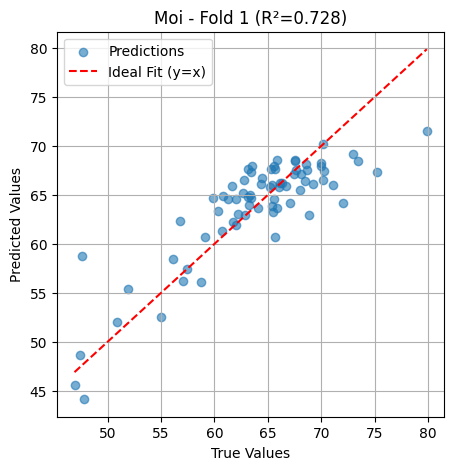

NDF: RMSE=4.924, R2=0.159, Bias=0.263


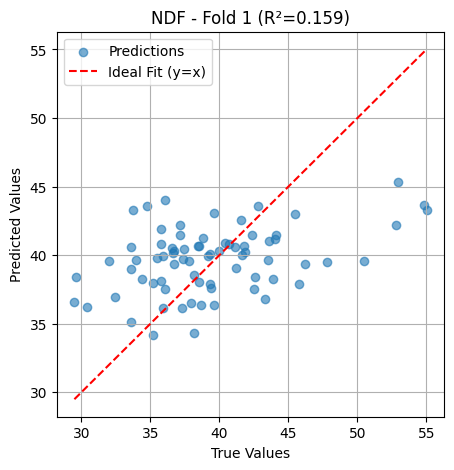

Starch: RMSE=7.812, R2=0.185, Bias=0.252


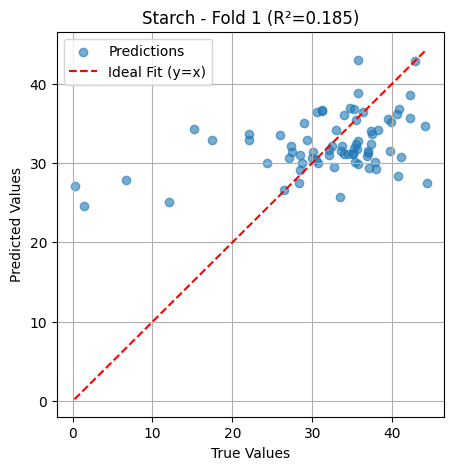


========== Fold 2/5 ==========


Training Fold 2:   5%|▌         | 10/200 [00:14<04:26,  1.40s/it]

Epoch 10/200 | Train Loss: 0.9281 | Val Loss: 1.0451


Training Fold 2:  10%|█         | 20/200 [00:28<04:07,  1.38s/it]

Epoch 20/200 | Train Loss: 0.9087 | Val Loss: 0.9671


Training Fold 2:  15%|█▌        | 30/200 [00:42<03:53,  1.37s/it]

Epoch 30/200 | Train Loss: 0.8828 | Val Loss: 0.9143


Training Fold 2:  20%|██        | 40/200 [00:56<03:42,  1.39s/it]

Epoch 40/200 | Train Loss: 0.8643 | Val Loss: 0.8955


Training Fold 2:  25%|██▌       | 50/200 [01:09<03:23,  1.36s/it]

Epoch 50/200 | Train Loss: 0.7775 | Val Loss: 0.8651


Training Fold 2:  30%|███       | 60/200 [01:23<03:11,  1.37s/it]

Epoch 60/200 | Train Loss: 0.6618 | Val Loss: 0.7208


Training Fold 2:  35%|███▌      | 70/200 [01:37<02:56,  1.36s/it]

Epoch 70/200 | Train Loss: 0.7075 | Val Loss: 0.7328


Training Fold 2:  40%|████      | 80/200 [01:51<02:44,  1.37s/it]

Epoch 80/200 | Train Loss: 0.6256 | Val Loss: 0.6918


Training Fold 2:  45%|████▌     | 90/200 [02:05<02:32,  1.38s/it]

Epoch 90/200 | Train Loss: 0.5630 | Val Loss: 0.6577


Training Fold 2:  50%|█████     | 100/200 [02:19<02:19,  1.39s/it]

Epoch 100/200 | Train Loss: 0.5580 | Val Loss: 0.6407


Training Fold 2:  55%|█████▌    | 110/200 [02:33<02:05,  1.39s/it]

Epoch 110/200 | Train Loss: 0.5696 | Val Loss: 0.6756


Training Fold 2:  60%|██████    | 120/200 [02:47<01:52,  1.41s/it]

Epoch 120/200 | Train Loss: 0.5329 | Val Loss: 0.6310


Training Fold 2:  65%|██████▌   | 130/200 [03:01<01:39,  1.42s/it]

Epoch 130/200 | Train Loss: 0.5421 | Val Loss: 0.6342


Training Fold 2:  70%|███████   | 140/200 [03:15<01:25,  1.43s/it]

Epoch 140/200 | Train Loss: 0.6719 | Val Loss: 0.7766


Training Fold 2:  70%|███████   | 141/200 [03:18<01:22,  1.41s/it]


🛑 Early Stopping at epoch 142 (no improvement for 15 epochs)



Fold Results:
Moi: RMSE=4.656, R2=0.478, Bias=2.789


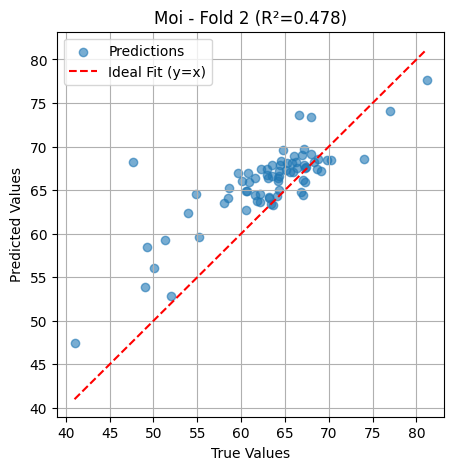

NDF: RMSE=4.897, R2=0.189, Bias=0.617


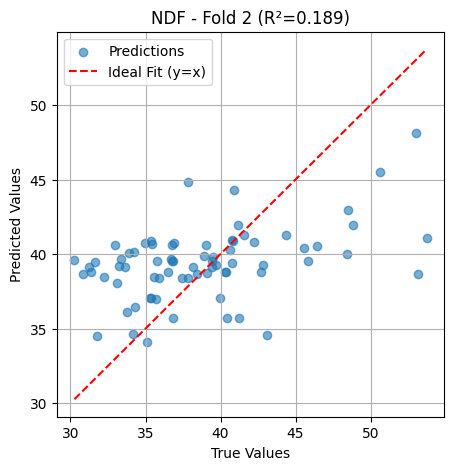

Starch: RMSE=7.438, R2=0.273, Bias=-0.395


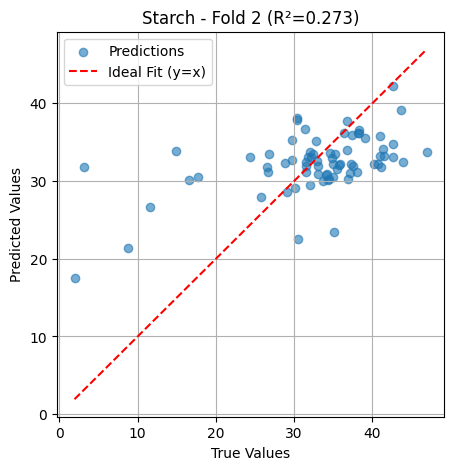


========== Fold 3/5 ==========


Training Fold 3:   5%|▌         | 10/200 [00:13<04:20,  1.37s/it]

Epoch 10/200 | Train Loss: 0.9162 | Val Loss: 1.1773


Training Fold 3:  10%|█         | 20/200 [00:27<04:05,  1.36s/it]

Epoch 20/200 | Train Loss: 0.9303 | Val Loss: 1.1878


Training Fold 3:  12%|█▏        | 23/200 [00:32<04:13,  1.43s/it]


🛑 Early Stopping at epoch 24 (no improvement for 15 epochs)



Fold Results:
Moi: RMSE=5.610, R2=-0.020, Bias=-0.924


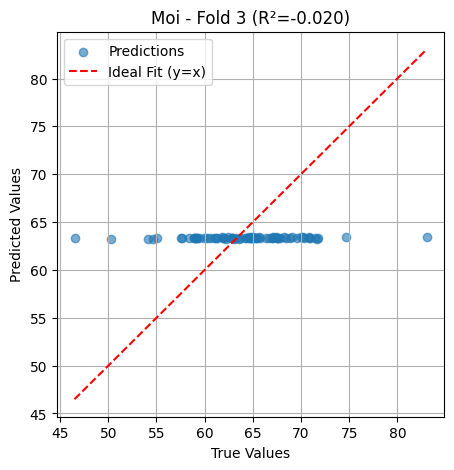

NDF: RMSE=7.839, R2=-0.011, Bias=-0.806


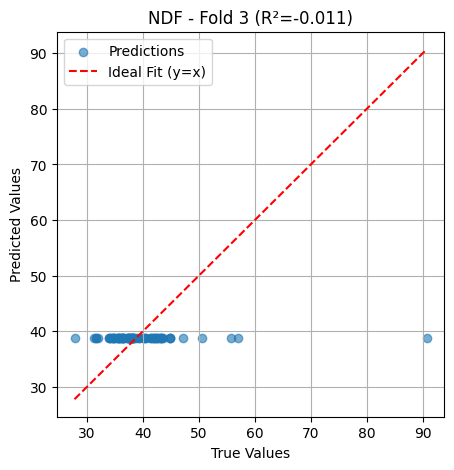

Starch: RMSE=8.558, R2=-0.004, Bias=0.555


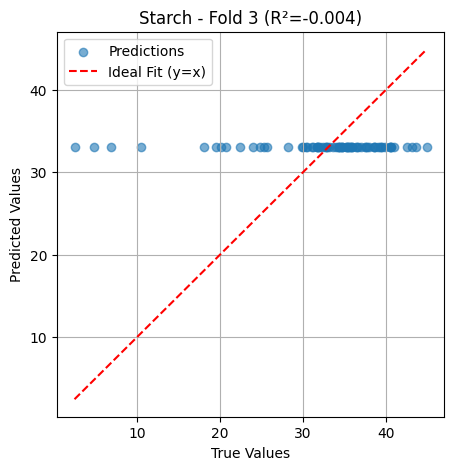


========== Fold 4/5 ==========


Training Fold 4:   5%|▌         | 10/200 [00:13<04:21,  1.37s/it]

Epoch 10/200 | Train Loss: 1.0133 | Val Loss: 0.9421


Training Fold 4:  10%|█         | 20/200 [00:27<04:10,  1.39s/it]

Epoch 20/200 | Train Loss: 0.9385 | Val Loss: 0.8864


Training Fold 4:  15%|█▌        | 30/200 [00:41<04:00,  1.41s/it]

Epoch 30/200 | Train Loss: 0.8998 | Val Loss: 0.8873


Training Fold 4:  20%|██        | 40/200 [00:55<03:48,  1.43s/it]

Epoch 40/200 | Train Loss: 0.8991 | Val Loss: 0.8605


Training Fold 4:  25%|██▌       | 50/200 [01:09<03:30,  1.41s/it]

Epoch 50/200 | Train Loss: 0.9092 | Val Loss: 0.8484


Training Fold 4:  30%|███       | 60/200 [01:22<03:14,  1.39s/it]

Epoch 60/200 | Train Loss: 0.7500 | Val Loss: 0.8282


Training Fold 4:  35%|███▌      | 70/200 [01:36<03:07,  1.44s/it]

Epoch 70/200 | Train Loss: 0.8648 | Val Loss: 0.8014


Training Fold 4:  40%|████      | 80/200 [01:50<02:46,  1.39s/it]

Epoch 80/200 | Train Loss: 0.6485 | Val Loss: 0.6399


Training Fold 4:  45%|████▌     | 90/200 [02:04<02:32,  1.38s/it]

Epoch 90/200 | Train Loss: 0.6911 | Val Loss: 0.6905


Training Fold 4:  50%|█████     | 100/200 [02:17<02:19,  1.39s/it]

Epoch 100/200 | Train Loss: 0.6191 | Val Loss: 0.6204


Training Fold 4:  55%|█████▌    | 110/200 [02:31<02:03,  1.37s/it]

Epoch 110/200 | Train Loss: 0.5889 | Val Loss: 0.6058


Training Fold 4:  60%|██████    | 120/200 [02:45<01:49,  1.37s/it]

Epoch 120/200 | Train Loss: 0.5611 | Val Loss: 0.5480


Training Fold 4:  65%|██████▌   | 130/200 [02:59<01:36,  1.37s/it]

Epoch 130/200 | Train Loss: 0.4966 | Val Loss: 0.4796


Training Fold 4:  70%|███████   | 140/200 [03:13<01:21,  1.37s/it]

Epoch 140/200 | Train Loss: 0.4867 | Val Loss: 0.4771


Training Fold 4:  75%|███████▌  | 150/200 [03:26<01:08,  1.37s/it]

Epoch 150/200 | Train Loss: 0.4587 | Val Loss: 0.4508


Training Fold 4:  80%|████████  | 160/200 [03:40<00:54,  1.36s/it]

Epoch 160/200 | Train Loss: 0.4495 | Val Loss: 0.4515


Training Fold 4:  85%|████████▌ | 170/200 [03:54<00:40,  1.37s/it]

Epoch 170/200 | Train Loss: 0.5538 | Val Loss: 0.4567


Training Fold 4:  90%|█████████ | 180/200 [04:08<00:26,  1.35s/it]

Epoch 180/200 | Train Loss: 0.4264 | Val Loss: 0.4147


Training Fold 4:  95%|█████████▌| 190/200 [04:21<00:13,  1.35s/it]

Epoch 190/200 | Train Loss: 0.4044 | Val Loss: 0.4107


Training Fold 4:  98%|█████████▊| 195/200 [04:30<00:06,  1.39s/it]


🛑 Early Stopping at epoch 196 (no improvement for 15 epochs)



Fold Results:
Moi: RMSE=2.789, R2=0.780, Bias=-0.387


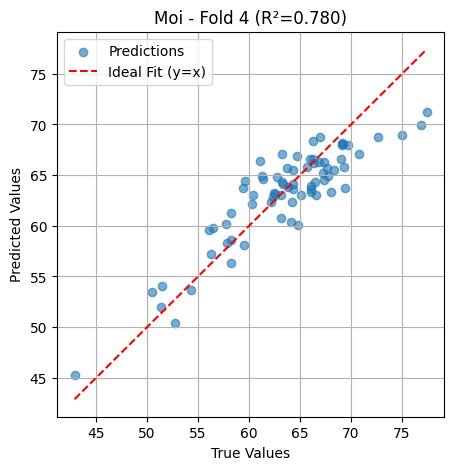

NDF: RMSE=4.033, R2=0.394, Bias=-0.152


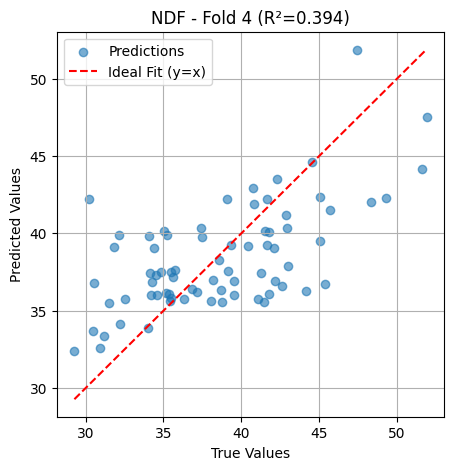

Starch: RMSE=6.687, R2=0.344, Bias=0.169


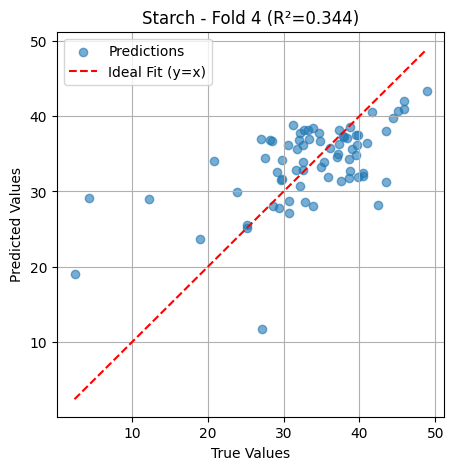


========== Fold 5/5 ==========


Training Fold 5:   5%|▌         | 10/200 [00:13<04:23,  1.39s/it]

Epoch 10/200 | Train Loss: 1.0117 | Val Loss: 0.8128


Training Fold 5:  10%|█         | 20/200 [00:27<04:08,  1.38s/it]

Epoch 20/200 | Train Loss: 0.9734 | Val Loss: 0.7383


Training Fold 5:  15%|█▌        | 30/200 [00:41<03:50,  1.36s/it]

Epoch 30/200 | Train Loss: 0.9192 | Val Loss: 0.7019


Training Fold 5:  20%|██        | 40/200 [00:54<03:36,  1.36s/it]

Epoch 40/200 | Train Loss: 0.8966 | Val Loss: 0.7284


Training Fold 5:  25%|██▌       | 50/200 [01:08<03:23,  1.36s/it]

Epoch 50/200 | Train Loss: 0.8898 | Val Loss: 0.6560


Training Fold 5:  30%|███       | 60/200 [01:22<03:13,  1.38s/it]

Epoch 60/200 | Train Loss: 0.8428 | Val Loss: 0.5889


Training Fold 5:  35%|███▌      | 70/200 [01:36<02:57,  1.36s/it]

Epoch 70/200 | Train Loss: 0.7520 | Val Loss: 0.4570


Training Fold 5:  40%|████      | 80/200 [01:50<02:42,  1.35s/it]

Epoch 80/200 | Train Loss: 0.7162 | Val Loss: 0.6340


Training Fold 5:  45%|████▌     | 90/200 [02:04<02:29,  1.36s/it]

Epoch 90/200 | Train Loss: 0.5971 | Val Loss: 0.4305


Training Fold 5:  50%|█████     | 100/200 [02:17<02:12,  1.33s/it]

Epoch 100/200 | Train Loss: 0.6255 | Val Loss: 0.4040


Training Fold 5:  55%|█████▌    | 110/200 [02:31<02:01,  1.35s/it]

Epoch 110/200 | Train Loss: 0.5977 | Val Loss: 0.4085


Training Fold 5:  60%|██████    | 120/200 [02:45<01:48,  1.36s/it]

Epoch 120/200 | Train Loss: 0.5410 | Val Loss: 0.3863


Training Fold 5:  65%|██████▌   | 130/200 [02:59<01:35,  1.36s/it]

Epoch 130/200 | Train Loss: 0.5474 | Val Loss: 0.3789


Training Fold 5:  68%|██████▊   | 137/200 [03:10<01:27,  1.39s/it]


🛑 Early Stopping at epoch 138 (no improvement for 15 epochs)



Fold Results:
Moi: RMSE=2.954, R2=0.785, Bias=-1.686


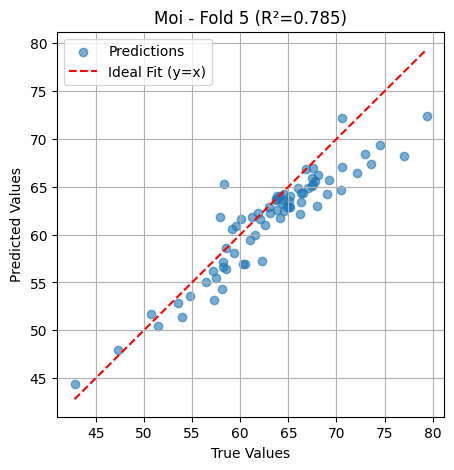

NDF: RMSE=4.257, R2=0.221, Bias=-0.682


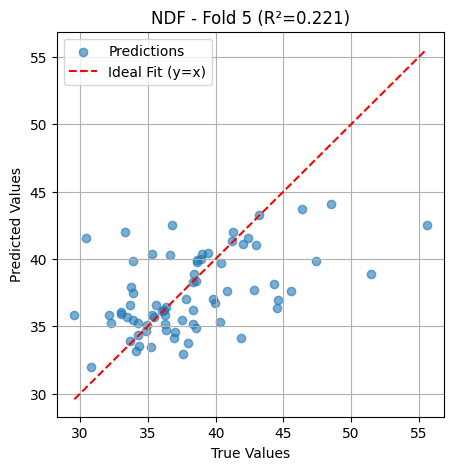

Starch: RMSE=5.987, R2=0.263, Bias=0.709


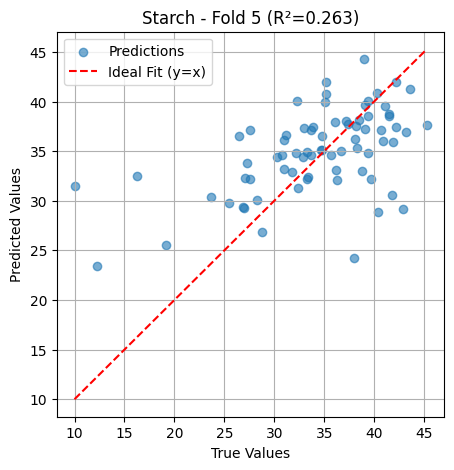



===== 📊 Average Results Across All Folds =====
Moi: Avg RMSE=3.860, Avg R2=0.551, Avg Bias=-0.044
NDF: Avg RMSE=5.190, Avg R2=0.191, Avg Bias=-0.152
Starch: Avg RMSE=7.296, Avg R2=0.212, Avg Bias=0.258


In [13]:
# =============================================
# ====== 9. 5-Fold Cross Validation ======
# =============================================
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# To store results for all folds
fold_metrics = {t: {'RMSE': [], 'R2': [], 'Bias': []} for t in TARGETS}

for fold, (t_idx, v_idx) in enumerate(kf.split(np.arange(len(trainval_idx)))):
    print(f"\n========== Fold {fold + 1}/{n_splits} ==========")

    # DataLoaders
    train_loader = DataLoader(Subset(dataset, trainval_idx[t_idx]), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, trainval_idx[v_idx]), batch_size=batch_size, shuffle=False)

    model = CNN2D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # ===== Early Stopping parameters =====
    best_val_loss = float('inf')
    patience = 15
    wait = 0
    best_model_state = None

    # ===== Training =====
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training Fold {fold + 1}"):
        model.train()
        epoch_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        # ===== Validation =====
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb.to(device))
                loss = criterion(preds, yb.to(device))
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Early Stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\n🛑 Early Stopping at epoch {epoch} (no improvement for {patience} epochs)")
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ===== Load best model =====
    model.load_state_dict(best_model_state)

    # ===== Validation (Final Metrics) =====
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true.append(yb_orig)
            y_pred.append(preds_orig)

    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

    # ===== Metrics =====
    metrics = compute_metrics_orig(y_true, y_pred)
    print("\nFold Results:")
    for i, t in enumerate(TARGETS):
        rmse, r2, bias = metrics[i]['RMSE'], metrics[i]['R2'], metrics[i]['Bias']
        fold_metrics[t]['RMSE'].append(rmse)
        fold_metrics[t]['R2'].append(r2)
        fold_metrics[t]['Bias'].append(bias)
        print(f"{t}: RMSE={rmse:.3f}, R2={r2:.3f}, Bias={bias:.3f}")

        # ===== Plot Regression =====
        plt.figure(figsize=(5, 5))
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"{t} - Fold {fold + 1} (R²={r2:.3f})")
        plt.legend()
        plt.grid(True)
        plt.show()

# =============================================
# ====== Average Metrics Across Folds ======
# =============================================
print("\n\n===== 📊 Average Results Across All Folds =====")
for t in TARGETS:
    avg_rmse = np.mean(fold_metrics[t]['RMSE'])
    avg_r2   = np.mean(fold_metrics[t]['R2'])
    avg_bias = np.mean(fold_metrics[t]['Bias'])
    print(f"{t}: Avg RMSE={avg_rmse:.3f}, Avg R2={avg_r2:.3f}, Avg Bias={avg_bias:.3f}")



=== Final Training on Full Train+Val Set ===
Epoch 10/200 | Train Loss: 0.9157 | Val Loss: 0.8641
Epoch 20/200 | Train Loss: 0.8500 | Val Loss: 0.8196
Epoch 30/200 | Train Loss: 0.8442 | Val Loss: 0.8050
Epoch 40/200 | Train Loss: 0.7864 | Val Loss: 0.8593
Epoch 50/200 | Train Loss: 0.8057 | Val Loss: 0.7679
Epoch 60/200 | Train Loss: 0.7496 | Val Loss: 0.7529
Epoch 70/200 | Train Loss: 0.6897 | Val Loss: 0.6518
Epoch 80/200 | Train Loss: 0.6256 | Val Loss: 0.5927
Epoch 90/200 | Train Loss: 0.5582 | Val Loss: 0.5622
Epoch 100/200 | Train Loss: 0.5151 | Val Loss: 0.4961
Epoch 110/200 | Train Loss: 0.4691 | Val Loss: 0.4809
Epoch 120/200 | Train Loss: 0.5094 | Val Loss: 0.5389
Epoch 130/200 | Train Loss: 0.4720 | Val Loss: 0.4496
Epoch 140/200 | Train Loss: 0.6672 | Val Loss: 0.4014
Epoch 150/200 | Train Loss: 0.4514 | Val Loss: 0.4556
Epoch 160/200 | Train Loss: 0.4471 | Val Loss: 0.4185
Epoch 170/200 | Train Loss: 0.4547 | Val Loss: 0.3958
Epoch 180/200 | Train Loss: 0.3965 | Val Loss

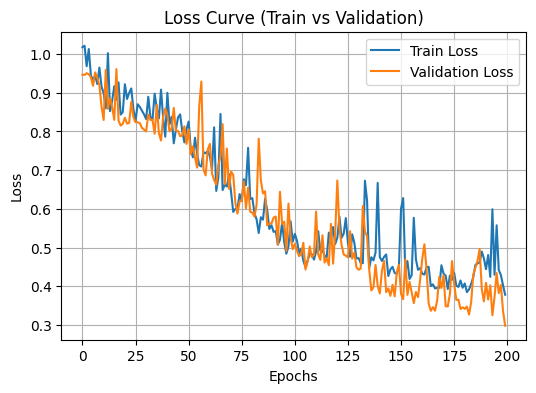

In [14]:
# =============================================
# ====== 10. Final Training with Loss Curve ======
# =============================================
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.2, random_state=seed)
final_loader = DataLoader(Subset(dataset, trainval_idx), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

final_model = CNN2D().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses = []
val_losses   = []

print("\n=== Final Training on Full Train+Val Set ===")
for epoch in range(1, epochs + 1):
    final_model.train()
    epoch_loss = 0.0
    for xb, yb in final_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(final_loader))

    # Validation loss
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = final_model(xb)
            val_loss += criterion(preds, yb).item()
    val_losses.append(val_loss / len(val_loader))

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve (Train vs Validation)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# =============================================
# ====== 11. Final Evaluation (Train/Val/Test) ======
# =============================================
def evaluate(model, loader, scaler):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = scaler.inverse_transform(preds)
            yb_orig = scaler.inverse_transform(yb_np)
            y_true.append(yb_orig)
            y_pred.append(preds_orig)
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    return y_true, y_pred


train_true, train_pred = evaluate(final_model, final_loader, y_scaler)
val_true, val_pred     = evaluate(final_model, val_loader, y_scaler)
test_true, test_pred   = evaluate(final_model, test_loader, y_scaler)

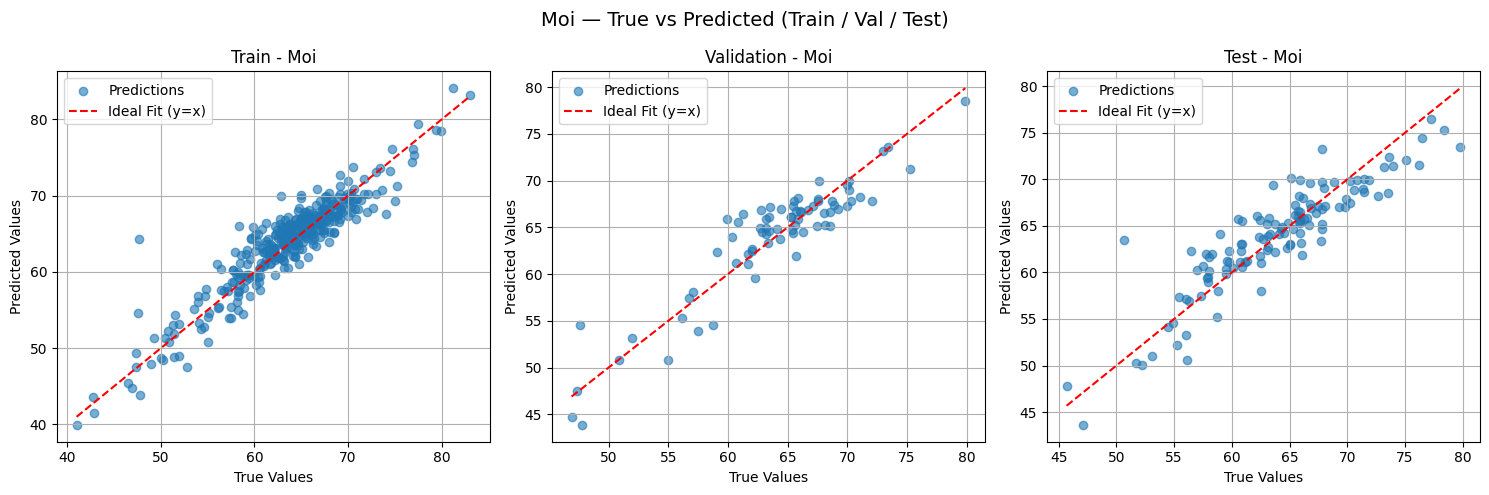

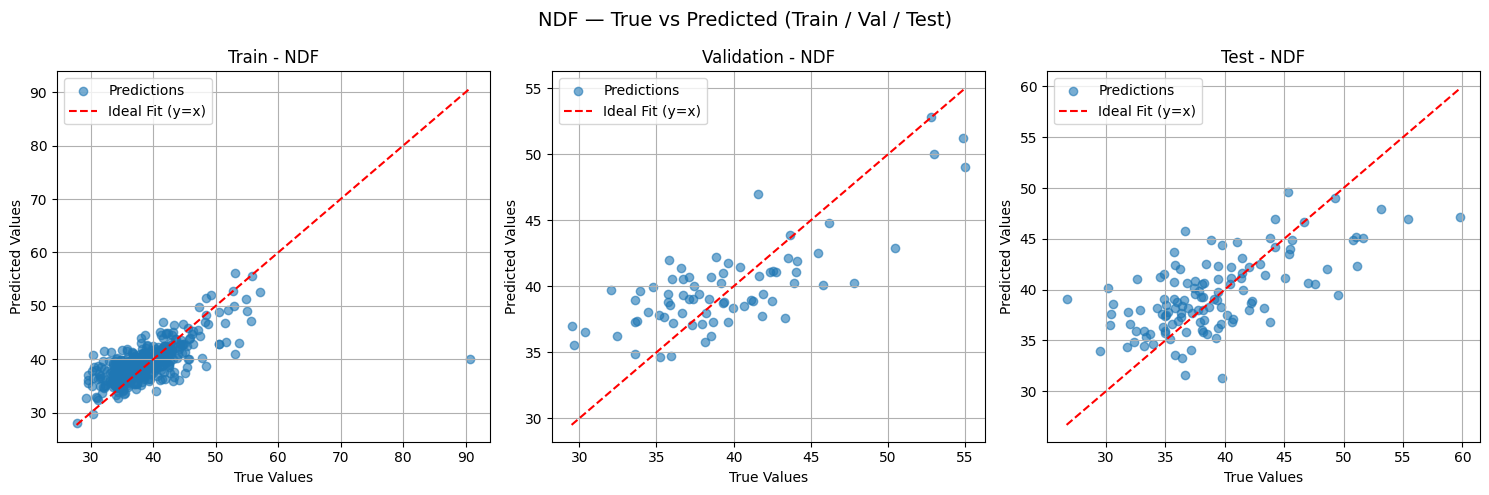

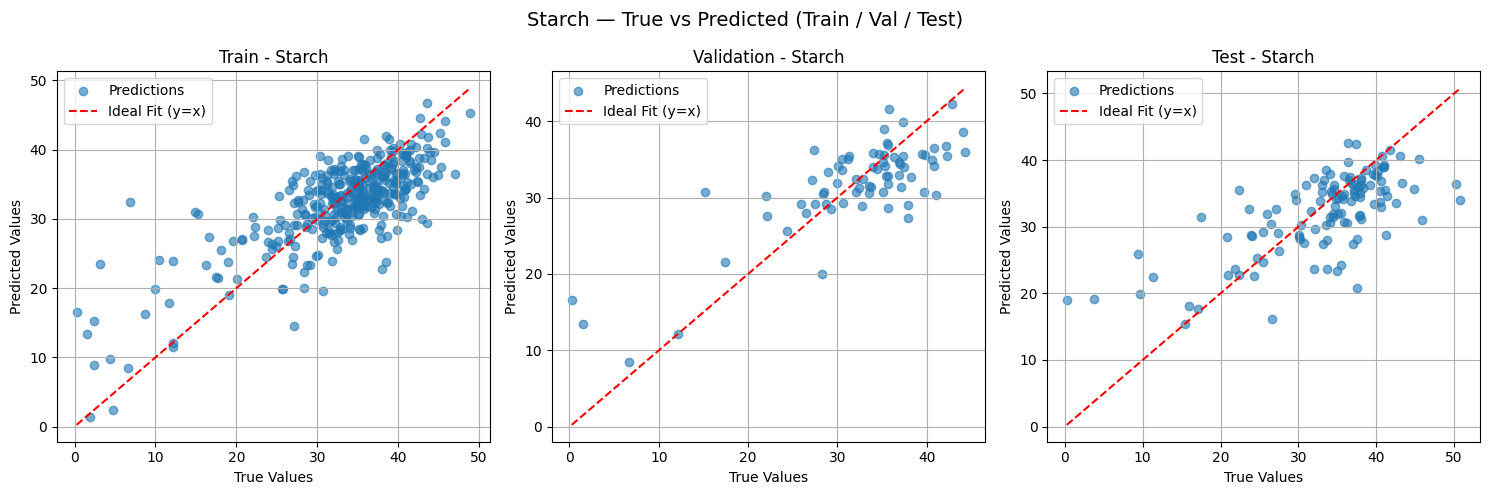

In [16]:
# =============================================
# ====== 12. Plot All Targets (Train/Val/Test) ======
# =============================================
for i, t in enumerate(TARGETS):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    datasets = [("Train", train_true, train_pred),
                ("Validation", val_true, val_pred),
                ("Test", test_true, test_pred)]

    for ax, (name, y_true, y_pred) in zip(axes, datasets):
        ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        ax.set_xlabel("True Values")
        ax.set_ylabel("Predicted Values")
        ax.set_title(f"{name} - {t}")
        ax.legend()
        ax.grid(True)

    plt.suptitle(f"{t} — True vs Predicted (Train / Val / Test)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [18]:
# =============================================
# ====== 13. Compute and Print Metrics ======
# =============================================
def print_metrics(name, y_true, y_pred):
    metrics = compute_metrics_orig(y_true, y_pred)
    print(f"\n📊 {name} Results:")
    for i, t in enumerate(TARGETS):
        rmse = metrics[i]['RMSE']
        r2   = metrics[i]['R2']
        bias = metrics[i]['Bias']
        print(f"🎯 {t}: R²: {r2:.4f}  RMSE: {rmse:.4f}  Bias: {bias:.4f}")
print_metrics("Train", train_true, train_pred)
print_metrics("Validation", val_true, val_pred)
print_metrics("Test", test_true, test_pred)



📊 Train Results:
🎯 Moi: R²: 0.8584  RMSE: 2.3156  Bias: 0.3348
🎯 NDF: R²: 0.4464  RMSE: 4.3475  Bias: 0.5510
🎯 Starch: R²: 0.5865  RMSE: 5.3334  Bias: -0.8154

📊 Validation Results:
🎯 Moi: R²: 0.8495  RMSE: 2.4492  Bias: 0.0981
🎯 NDF: R²: 0.5673  RMSE: 3.5321  Bias: 0.5097
🎯 Starch: R²: 0.6260  RMSE: 5.2910  Bias: -0.3997

📊 Test Results:
🎯 Moi: R²: 0.8026  RMSE: 2.7795  Bias: 0.0601
🎯 NDF: R²: 0.3985  RMSE: 4.3569  Bias: 0.5263
🎯 Starch: R²: 0.4702  RMSE: 6.2836  Bias: -1.0625


In [ ]:
# =============================================
# ====== 14. Save Final Model ======
# =============================================
file_path = f"/content/{base}.pth"
torch.save(final_model.state_dict(), file_path)
print(f"\n✅ Model saved to: {file_path}")

In [20]:
# =============================================
# ====== 15. Targets Info ======
# =============================================
for target in TARGETS:
    print(f"{target}: Min={df[target].min():.3f}, Max={df[target].max():.3f}")

Moi: Min=41.001, Max=83.060
NDF: Min=26.690, Max=90.740
Starch: Min=0.250, Max=50.800
